In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [2]:
task = 'recipient'

time: 1.49 ms


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 16.5 s


In [4]:
l_b = plurality(d_b[task].dropna())
l_r = plurality(d_r[task].dropna())

time: 27.5 s


In [5]:
l_b.value_counts()

0.0    42871
1.0    10544
Name: y, dtype: int64

time: 5.29 ms


In [6]:
l_r.value_counts()

0.0    19833
1.0      160
Name: y, dtype: int64

time: 3.34 ms


In [7]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 685 ms


### Split into train/dev and test

In [8]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 43.4 ms


In [9]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 5.7 ms


In [10]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.7 ms


In [11]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

15

time: 31.6 ms


### NGram Classification Pipeline

In [33]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.0001, 0.01, 0.1, 1 ,5,10),
    #'clf__class_weight': ('balanced', None)
}

time: 6.26 ms


### Hyper-Parameter tuning

In [34]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)


Best parameters set found:
{'clf__C': 5, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'} 0.942947737662


Grid scores:
0.86564 (+/-0.00051) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.85497 (+/-0.00026) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.86205 (+/-0.00038) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 10000, 'vect__analyzer': 'char'}
0.87068 (+/-0.00055) for {'clf__C': 0.0001, 'vect__ngram_range': (1, 6), 'vect__max_features': 50000, 'vect__analyzer': 'char'}
0.88167 (+/-0.00048) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'vect__analyzer': 'char'}
0.89039 (+/-0.00031) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_features': 5000, 'vect__analyzer': 'char'}
0.89365 (+/-0.00018) for {'clf__C': 0.01, 'vect__ngram_range': (1, 6), 'vect__max_fea

In [12]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 1.86 ms


### Train on blocked

In [12]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 2min 20s


Eval on blocked


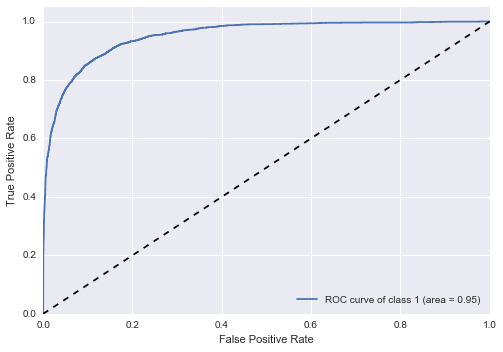

threshold @ optimal F1: 0.348855993719
{'optimal F1': '0.779',
 'precision @ optimal F1': '0.762',
 'recall @ optimal F1': '0.762',
 'roc': '0.952'}
time: 21.7 s


In [13]:
print('Eval on blocked')
_= eval_binary_classifier(b_model, b_test, calibration = False, roc = True)

Eval on random


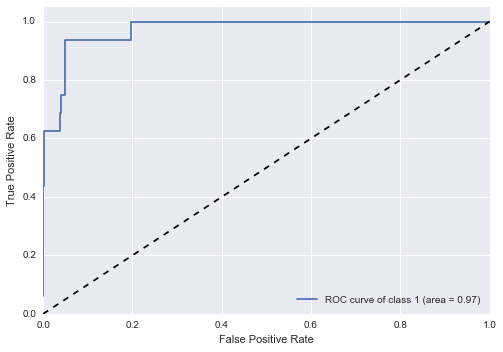

threshold @ optimal F1: 0.339370810759
{'optimal F1': '0.556',
 'precision @ optimal F1': '0.625',
 'recall @ optimal F1': '0.625',
 'roc': '0.973'}
time: 4.52 s


In [14]:
print('Eval on random')
_= eval_binary_classifier(b_model, r_test, calibration = False, roc = True)

### Train on random

In [15]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 22.3 s


Eval on blocked


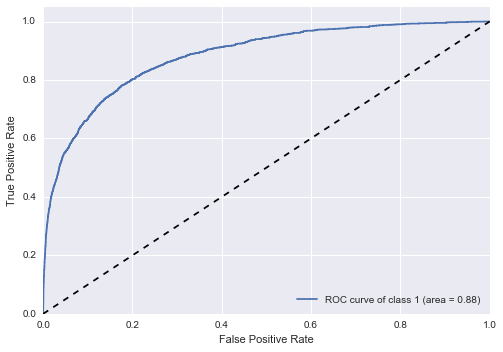

threshold @ optimal F1: 0.0137892034202
{'optimal F1': '0.647',
 'precision @ optimal F1': '0.649',
 'recall @ optimal F1': '0.649',
 'roc': '0.883'}
time: 19.4 s


In [16]:
print('Eval on blocked')
_= eval_binary_classifier(r_model, b_test, calibration = False, roc = True)

Eval on random


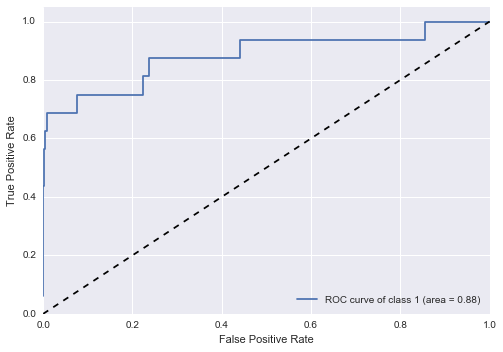

threshold @ optimal F1: 0.0216094619885
{'optimal F1': '0.556',
 'precision @ optimal F1': '0.625',
 'recall @ optimal F1': '0.625',
 'roc': '0.884'}
time: 3.8 s


In [17]:
print('Eval on random')
_= eval_binary_classifier(r_model, r_test, calibration = False, roc = True)

### Train on both

In [42]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 1min 30s


Eval on blocked


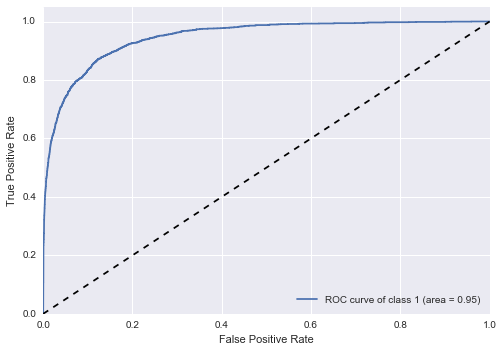

threshold @ optimal F1: 0.317397042443
{'optimal F1': '0.764',
 'precision @ optimal F1': '0.766',
 'recall @ optimal F1': '0.766',
 'roc': '0.946'}
time: 17.1 s


In [43]:
print('Eval on blocked')
_= eval_binary_classifier(br_model, b_test, calibration = False, roc = True)

Eval on random


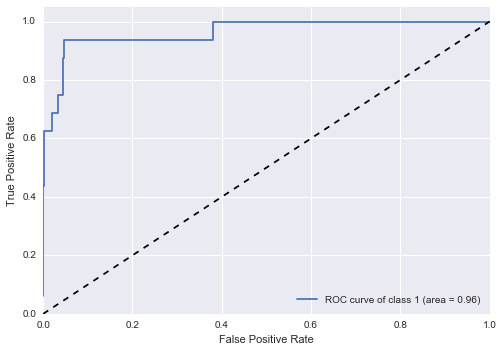

threshold @ optimal F1: 0.370378899409
{'optimal F1': '0.556',
 'precision @ optimal F1': '0.625',
 'recall @ optimal F1': '0.625',
 'roc': '0.964'}
time: 3.45 s


In [44]:
print('Eval on random')
_= eval_binary_classifier(br_model, r_test, calibration = False, roc = True)

Eval on both


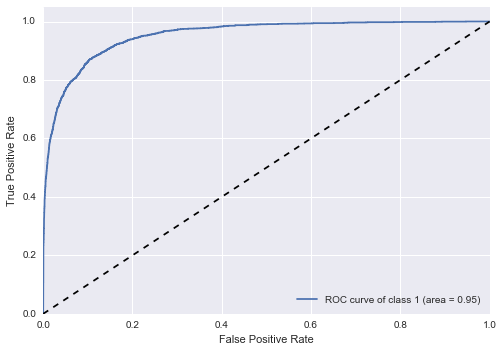

threshold @ optimal F1: 0.350812128697
{'optimal F1': '0.761',
 'precision @ optimal F1': '0.741',
 'recall @ optimal F1': '0.741',
 'roc': '0.953'}
time: 20.8 s


In [45]:
print('Eval on both')
_= eval_binary_classifier(br_model, br_test, calibration = False, roc = True)

### Check Calibration

threshold @ optimal F1: 0.350812128697
{'optimal F1': '0.761',
 'precision @ optimal F1': '0.741',
 'recall @ optimal F1': '0.741',
 'roc': '0.953'}


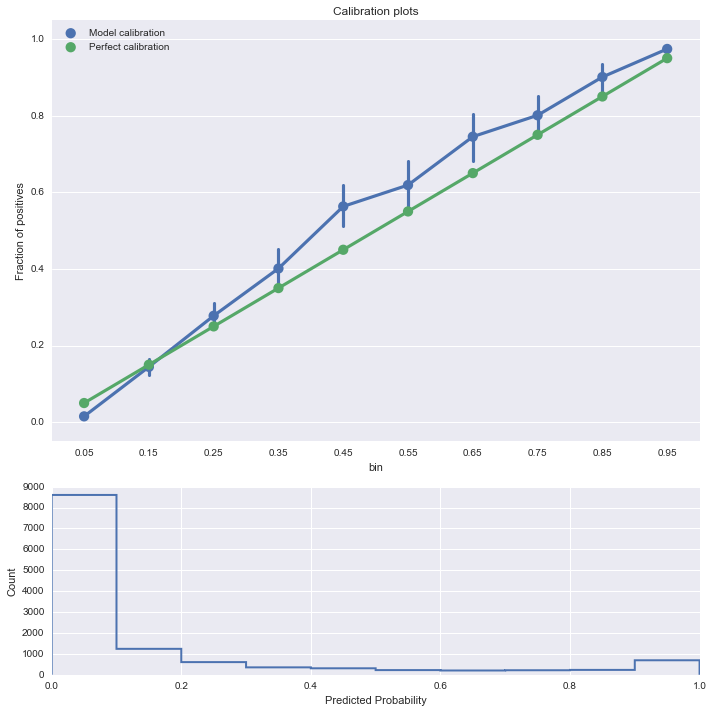

time: 19.3 s


In [144]:
_= eval_binary_classifier(br_model, br_test, calibration = True, roc = False)

threshold @ optimal F1: 0.317397042443
{'optimal F1': '0.764',
 'precision @ optimal F1': '0.766',
 'recall @ optimal F1': '0.766',
 'roc': '0.946'}


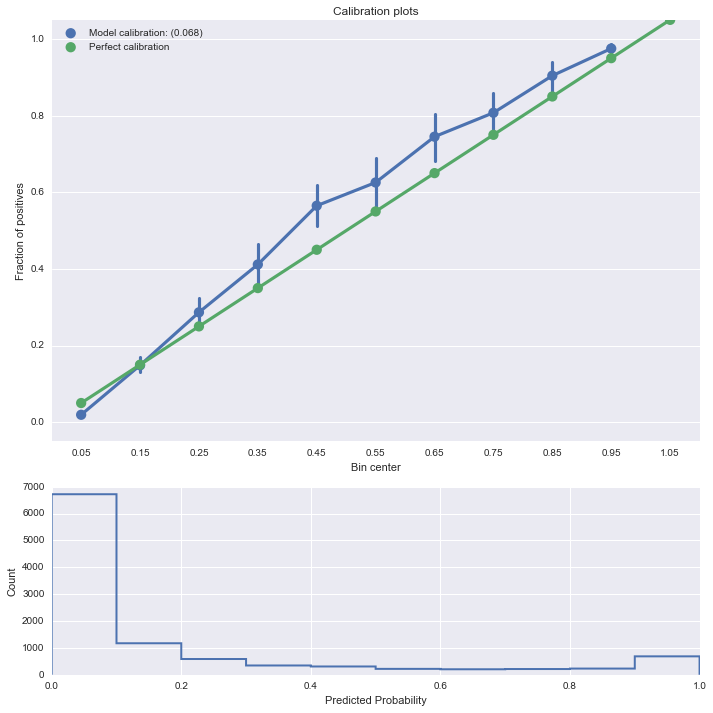

time: 15.7 s


In [148]:
_= eval_binary_classifier(br_model, b_test, calibration = True, roc = False)

threshold @ optimal F1: 0.370378899409
{'optimal F1': '0.556',
 'precision @ optimal F1': '0.625',
 'recall @ optimal F1': '0.625',
 'roc': '0.964'}


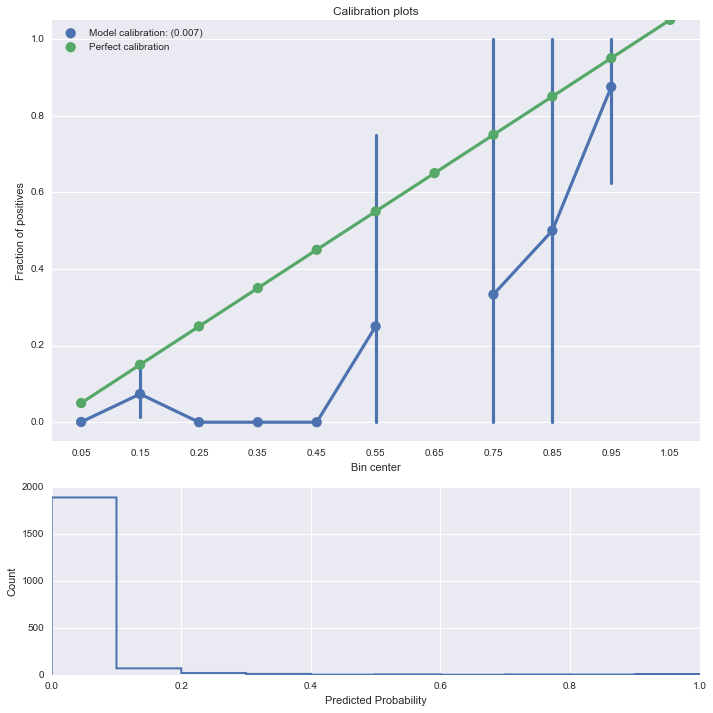

time: 3.42 s


In [149]:
_= eval_binary_classifier(br_model, r_test, calibration = True, roc = False)

### Error Analysis

In [24]:
fn, fp = get_clf_errors(br_model, br_test)

time: 50.8 s


In [25]:
# extreme False negatives
print_clf_errors(fn)

COMMENT:
"{{unblock|THANK YOU for a reasonable fucking comment!!! The ONLY USER in ANY AREA who has actually made one!!  (Ebyabe made comments which appear to be reasonable at first glance, but are actually unreasonable because one is fraudulent and the other was untrue regarding a place where she could see that it was untrue.)  Well a sort-of reasonable comment anyway because he claims that I am being ""confrontational"" when it is clearly visible at my talk page that other users are attacking me and no
SCORES: Actual: 1, Predicted: 0, Score: 0.00


COMMENT:
" Sitush you are a menace to Wikipedia as this conversation from the page of another editor shows - Are you a 15 year old kid trying his hand in editing academic articles??? First Lilit Shastri writes to Jonathan. This is because Sitush has just vandalized his article about Singahi Bhiraura and reduced it to four or five lines, via numerous reverts, here is the letter. Later you will see that  Sitush interjects and gives some lous

In [26]:
# extreme False positives
print_clf_errors(fp)

COMMENT:
ASSHOLE EdJohnston, FUCK YOU!!! EdJohnston IS a mother fucker!!!
SCORES: Actual: 0, Predicted: 1, Score: 1.00


COMMENT:
 wtf fuck this shit why the fuck wuld sum pussy liccking site be fucking offline? FUCK! 192.43.227.18  
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
 you are a cunt so how about a blowjob?
SCORES: Actual: 0, Predicted: 1, Score: 0.99


COMMENT:
i i wanna fuck a dog in the ass
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 Keep your head up man Don't let this uppity bitch get you down man, you are one of the better contributors to this shit.  
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 I'm going to kill you Zink Dawg your a Scrap and a fag and you need to die. I'm going to kill you if someone else doesn't. You better keep protecting your user space because I will keep vandalizing it.
SCORES: Actual: 0, Predicted: 1, Score: 0.98


COMMENT:
 Stay out of my business Go ahead, keep it up shithead, I'll kick your ass to!!! 
SCORE

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [13]:
def get_roc(model, test):
    return roc_auc_score(test['y'], model.predict_proba(test['x'])[:, 1])

time: 1.09 ms


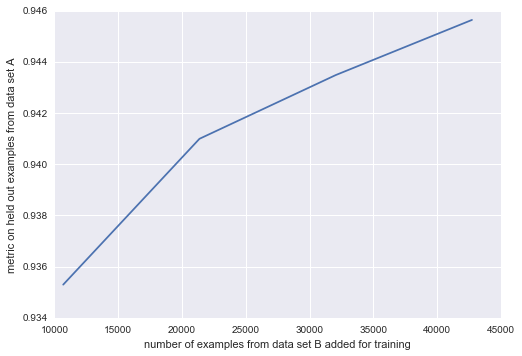

time: 3min 33s


In [15]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

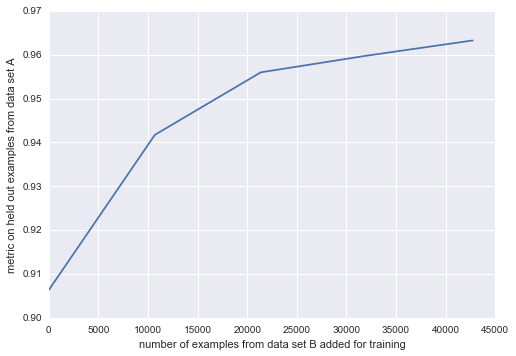

time: 5min 20s


In [16]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

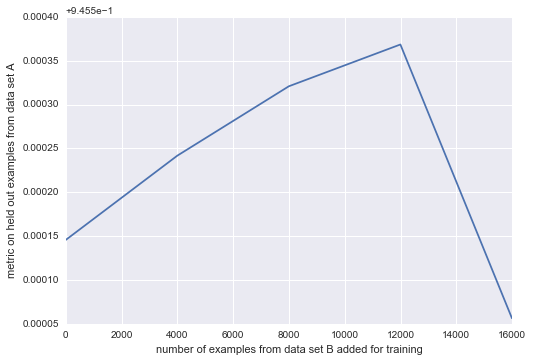

time: 7min 40s


In [17]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc)
plot_adding_other_data(ms, metrics)

# Final Model

In [36]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 1min 50s


# Model Understanding

In [55]:
understanding_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), analyzer = 'word', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 1.0, class_weight = None)),
])

time: 1.95 ms


In [126]:
model = understanding_pipeline.fit(br_train['x'], br_train['y'])

time: 3.27 s


In [127]:
clf = model.named_steps['clf']

time: 800 µs


In [128]:
coef_ = clf.coef_.ravel()

time: 957 µs


In [129]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())

time: 14.7 ms


In [130]:
most_pos_idx = np.argsort(coef_)[-100:]
most_pos = feature_names[most_pos_idx]

time: 1.72 ms


In [131]:
most_neg_idx = np.argsort(coef_)[:100]
most_neg = feature_names[most_neg_idx]

time: 1.82 ms


In [132]:
most_pos

array(['damn', 'quit', 'shove', 'arsehole', 'dicks', 'nazis', 'ты',
       'homosexual', 'fat', 'pig', 'fuc', 'stop', 'disgusting', 'anal',
       'face', 'yo', 'hate', 'fc', 'retarded', 'piss', 'lick', 'arse',
       'douche', 'head', 'wanker', 'smell', 'dickhead', 'jackass', 'penis',
       'balls', 'ck', 'fuckers', 'arrogant', 'life', 'nazi', 'pussy',
       'prick', 'ing', 'are', 'nigga', 'jerk', 'sex', 'youre', 'hole',
       'fuk', 'scum', 'nigger', 'gay', 'idiotic', 'yourself', 'douchebag',
       'kiss', 'little', 'fuckin', 'loser', 'fag', 'screw', 'dumbass',
       'bullshit', 'pathetic', 'ugly', 'cocksucker', 'coward', 'crap',
       'hypocrite', 'assholes', 'ignorant', 'hell', 'ur', 'idiots',
       'motherfucker', 'retard', 'kill', 'dumb', 'fuckhead', 'racist',
       'go', 'fucked', 'fool', 'off', 'faggot', 'cock', 'die', 'cunt',
       'shut', 'fucker', 'bastard', 'dick', 'ass', 'moron', 'bitch',
       'shit', 'suck', 'your', 'asshole', 'stupid', 'idiot', 'fucking',
    

time: 1.99 ms


In [133]:
most_neg

array(['thank', 'help', 'thanks', 'please', 'he', 'talk', 'to', 'they',
       'this', 'for', 'user', 'appreciate', 'if', 'song', 'articles',
       'issue', 'but', 'request', 'hi', 'him', 'welcome', 'love',
       'discussion', 'the', 'see', 'interested', 'billcj', 'against',
       'position', 'agree', 'username', 'comment', 'continue', 'suggest',
       'understand', 'might', 'at', 'reported', 'these', 'rfa', 'can',
       'great', 'cannot', 'riot', 'interesting', 'cool', 'notice', 'title',
       'section', 'editing', 'should', 'questions', 'hes', 'utc',
       'knowledge', 'al', 'is', 'saying', 'fix', 'article', 'work',
       'could', 'cheers', 'yes', 'response', 'we', 'also', 'there',
       'blocked', 'new', 'particular', 'from', 'music', 'dreadstar',
       'once', 'notable', 'through', 'simply', 'his', '2006',
       'contributions', 'summaries', 'currently', 'evidence', 'would',
       'january', 'link', 'more', 'luck', 'done', 'list', 'include',
       'worry', 'did', 'poin

time: 1.85 ms


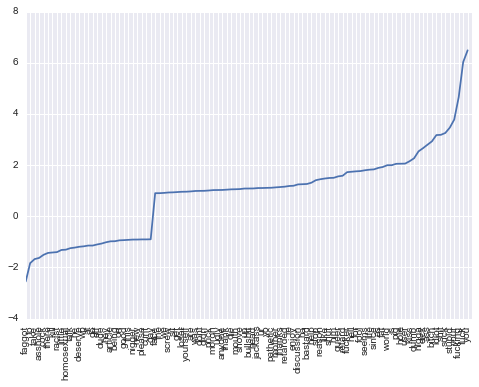

time: 644 ms


In [117]:
"""
coef = coef_.ravel()[important]
inds = np.argsort(coef)
f_imp = f_imp[inds]
coef = coef[inds]
plt.plot(coef, label="l1")
ax = plt.gca()
ax.set_xticks(np.arange(len(coef)))
labels = ax.set_xticklabels(f_imp)
for label in labels:
    label.set_rotation(90)
plt.show()

"""